# NN4MG model and analyze the mapped mesh

This prelimitary work is inspired from Prof. Maria K. Cameron's notebook "A variational neural network-based solver for the committor problem". For a PDE that can be expressed as a Euler-Lagrangian equation, its solution is identical to the minimizer of a calculous of variation problem. The commiter problem is formulated from the PDE, while our case is formulated from the variational problem. In out past works, we find the solution by solving the Euler-Lanrangian equation. But this approach has limitations: if we want to modify the misfit (the integrand of the functional), we need to put non-trivial effort to derive the new Euler-Lagrangian, find the diffusion coefficients and a correct discretization. Even worse, some reasonabel choices of misfit leads to Euler-Lagrangian that isn't uniformly elliptic and has singularities, which becomes impossible to be solved. Therefore, it worth to consider minimizing the variational problem directly. The easiest choice to try first is training a neural network as an approximation of $x(s)$ (or $s(x)$). 

Let $\mathcal{N}(s)=x$ be a $\mathbb{R}^2$ to $\mathbb{R}^2$ be a neural network,

We propose a solution model: 
$$x_1(s) = x_1^0(s) + s_1(1-s_1)\mathcal{N}_1(s)$$
$$x_2(s) = x_2^0(s) + s_2(1-s_2)\mathcal{N}_2(s)$$
Where $x_1^0(s)$ and $x_2^0(s)$ are the initial guess of the map from computational space to physical space. The quadratic coefficients s_1(1-s_1) and s_2(1-s_2) are here to strictly enforce Dirichlet boundary conditions: $x_1$ must equal to initial value where $s_1=0,1$, and $x_2$ must equal to initial value where $s_2=0,1$.

For now, a simple MLP is used as the neural network. 

The loss function is constructed as: $\mathcal{L} = \mathcal{L}_\text{int} + \mathcal{L}_\text{Neu}$. Where $\mathcal{L}_\text{int} = \frac{1}{N} \sum_k^N \sigma_1^2 M_{ij} x_{i,\alpha} x_{j,\alpha}$, the average of misfit values at grid points. And $\mathcal{L}_\text{Neu} = \text{Avg\_of\_North}(\partial_n x_1) + \text{Avg\_of\_South}(\partial_n x_1) + \text{Avg\_of\_West}(\partial_n x_2) + \text{Avg\_of\_East}(\partial_n x_2)$. The derivative of $x$ can be easily evaluated thanks to automatic differentiation.


In [7]:
%matplotlib inline
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import torch

from nn4mg import (
    compute_misfit_field,
    compute_skewness,
    load_grid_csv,
    M_fun_torch,
    M_fun_inv_torch,
    Model,
    plot_grid,
    plot_scalar_field,
)


In [8]:
run_dir = Path("models/20260113_151102")  # change me
# run_dir = Path("models/20260113_160001")
config_path = run_dir / "run_config.json"
model_path = run_dir / "model.pt"

config = json.loads(config_path.read_text()) if config_path.exists() else {}
args = config.get("args", {})
model_cfg = config.get("model", {})

width = model_cfg.get("width", args.get("width", 128))
depth = model_cfg.get("depth", args.get("depth", 4))
problem = args.get("problem", 1)
formulation = args.get("formulation", "primal")

grid_dir = Path(".")
x1_path = grid_dir / args.get("x1", "x1.csv")
x2_path = grid_dir / args.get("x2", "x2.csv")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

net = Model(width=width, depth=depth)
state = torch.load(model_path, map_location=device)
net.load_state_dict(state)
net.to(device=device, dtype=dtype)
net.eval()

print(f"Loaded model from: {model_path}")
print(f"width={width}, depth={depth}, problem={problem}, formulation={formulation}")


Loaded model from: models/20260113_151102/model.pt
width=128, depth=4, problem=1, formulation=primal


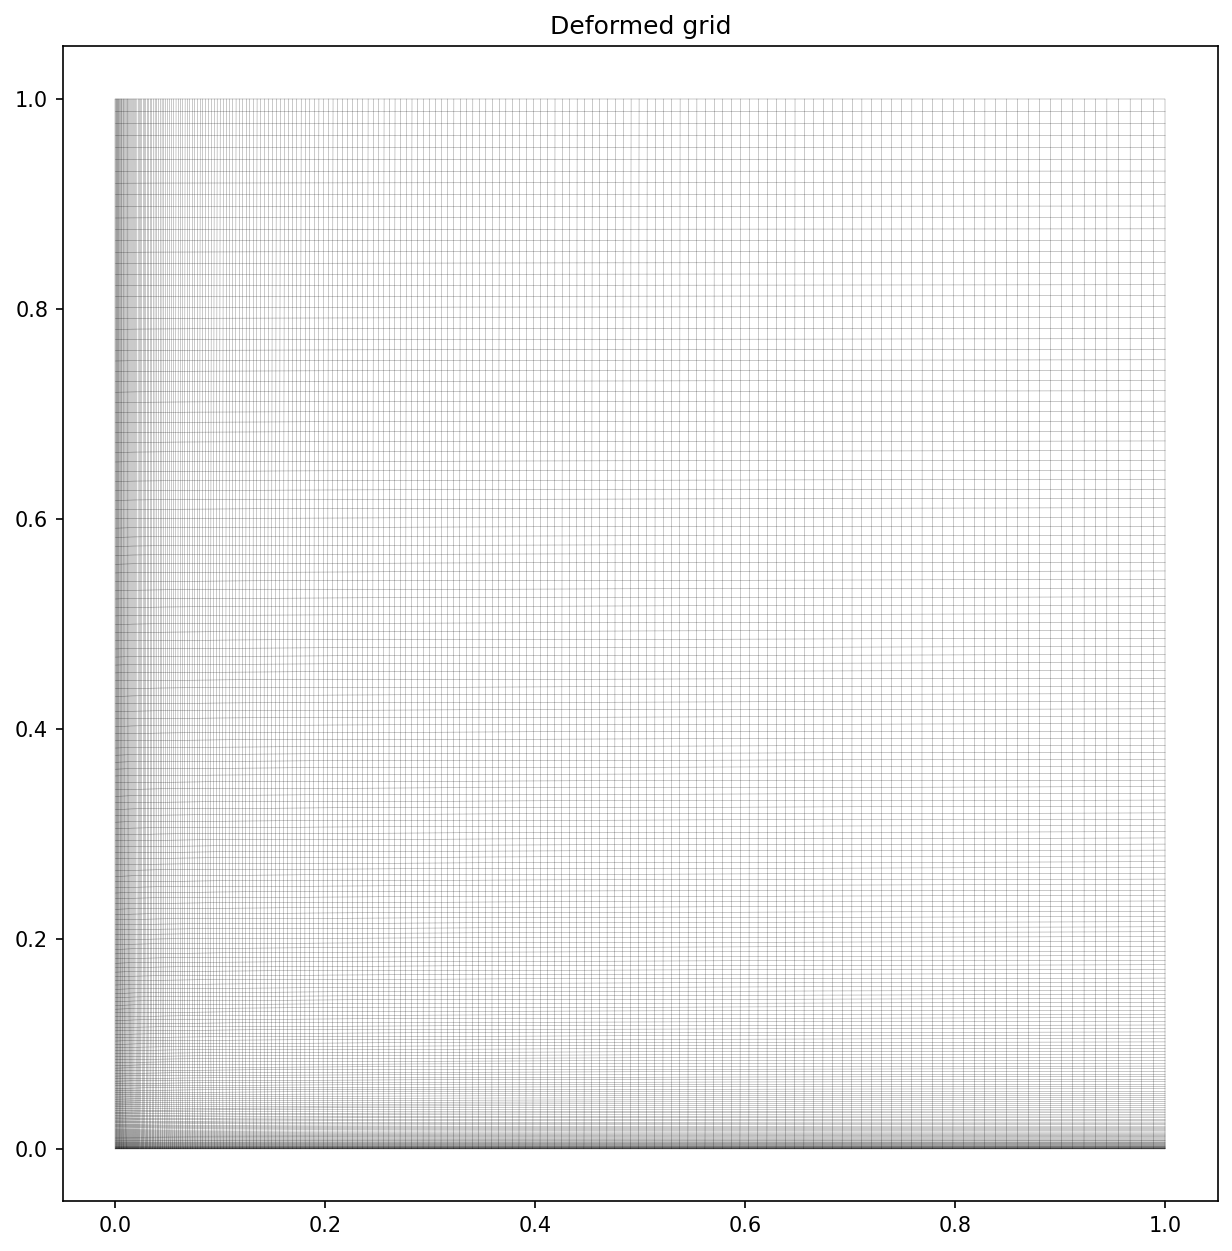

In [9]:
X1, X2 = load_grid_csv(x1_path, x2_path)
Nx1, Nx2 = np.shape(X1)

xy_int = np.concatenate(
    (X1.flatten().reshape(-1, 1), X2.flatten().reshape(-1, 1)), axis=1
)
xy_int = torch.from_numpy(xy_int).to(device=device, dtype=dtype)

with torch.no_grad():
    out = net(xy_int)

X = torch.reshape(out[:, 0], (Nx2, Nx1)).detach().cpu().numpy()
Y = torch.reshape(out[:, 1], (Nx2, Nx1)).detach().cpu().numpy()

plot_grid(X, Y, title="Deformed grid")
plt.show()


sigma1=0.024778, sigma2=0.023573
ideal cells: Nx1=40, Nx2=42


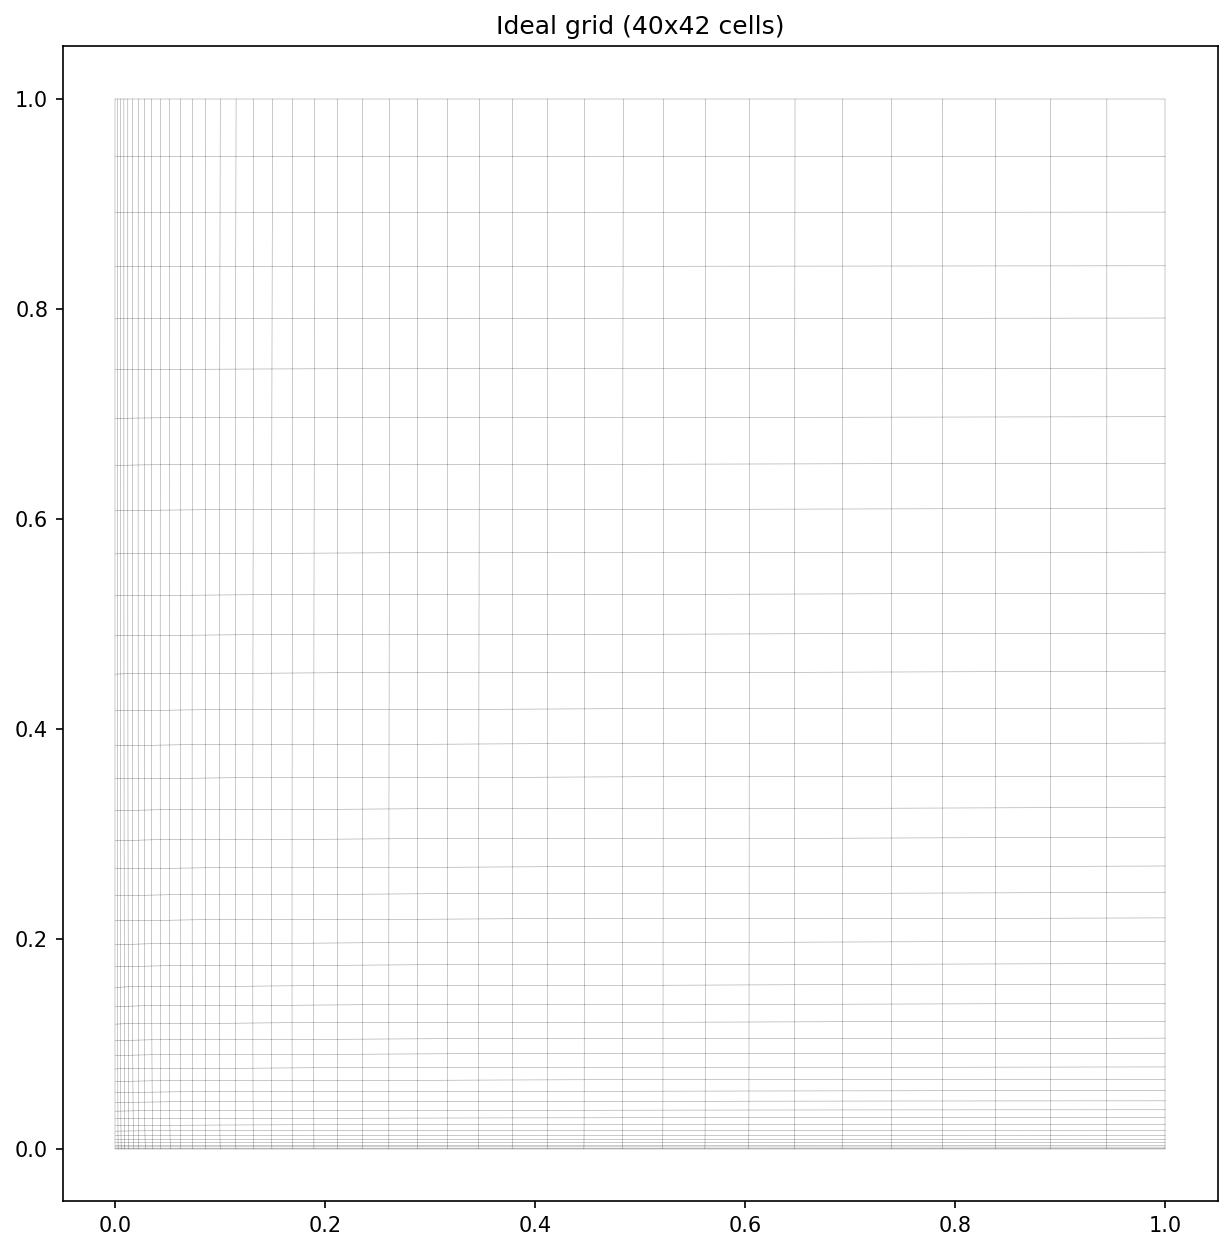

In [10]:
from nn4mg import M_fun
def dcentral(x1, x2, sigma1, sigma2):
    dx1ds1 = np.zeros_like(x1)
    dx2ds2 = np.zeros_like(x2)

    dx2ds2[1:-1, :] = (x2[2:, :] - x2[:-2, :]) / (2.0 * sigma2)
    dx2ds2[0, :] = (-x2[2, :] + 4 * x2[1, :] - 3 * x2[0, :]) / (2.0 * sigma2)
    dx2ds2[-1, :] = -(-x2[-3, :] + 4 * x2[-2, :] - 3 * x2[-1, :]) / (2.0 * sigma2)

    dx1ds1[:, 1:-1] = (x1[:, 2:] - x1[:, :-2]) / (2.0 * sigma1)
    dx1ds1[:, 0] = (-x1[:, 2] + 4 * x1[:, 1] - 3 * x1[:, 0]) / (2.0 * sigma1)
    dx1ds1[:, -1] = -(-x1[:, -3] + 4 * x1[:, -2] - 3 * x1[:, -1]) / (2.0 * sigma1)

    return dx1ds1, dx2ds2

ds1 = 1.0 / Nx1
ds2 = 1.0 / Nx2
dx1ds1, dx2ds2 = dcentral(X, Y, ds1, ds2)
dx2ds1, dx1ds2 = dcentral(Y, X, ds1, ds2)

M11, M12, M22 = M_fun(X, Y, problem=problem)
p1 = M11 * dx1ds1**2 + M22 * dx2ds1**2 + 2.0 * M12 * dx1ds1 * dx2ds1
p2 = M11 * dx1ds2**2 + M22 * dx2ds2**2 + 2.0 * M12 * dx1ds2 * dx2ds2

sigma1 = np.sqrt(np.sum(np.abs(p1)) / np.sum(p1**2))
sigma2 = np.sqrt(np.sum(np.abs(p2)) / np.sum(p2**2))
ideal_cells_x = max(1, int(np.round(1.0 / sigma1)))
ideal_cells_y = max(1, int(np.round(1.0 / sigma2)))
print(f"sigma1={sigma1:.6f}, sigma2={sigma2:.6f}")
print(f"ideal cells: Nx1={ideal_cells_x}, Nx2={ideal_cells_y}")

if formulation != "primal":
    print("Formulation is dual; ideal-grid plot assumes a primal map s->x.")
else:
    xi = np.linspace(0.0, 1.0, ideal_cells_x + 1)
    eta = np.linspace(0.0, 1.0, ideal_cells_y + 1)
    X1_ideal, X2_ideal = np.meshgrid(xi, eta)
    xy_ideal = np.column_stack((X1_ideal.ravel(), X2_ideal.ravel()))
    xy_ideal = torch.from_numpy(xy_ideal).to(device=device, dtype=dtype)
    with torch.no_grad():
        out_ideal = net(xy_ideal)

    X_ideal = out_ideal[:, 0].reshape(X1_ideal.shape).detach().cpu().numpy()
    Y_ideal = out_ideal[:, 1].reshape(X2_ideal.shape).detach().cpu().numpy()
    plot_grid(
        X_ideal,
        Y_ideal,
        title=f"Ideal grid ({ideal_cells_x}x{ideal_cells_y} cells)",
    )
    plt.show()


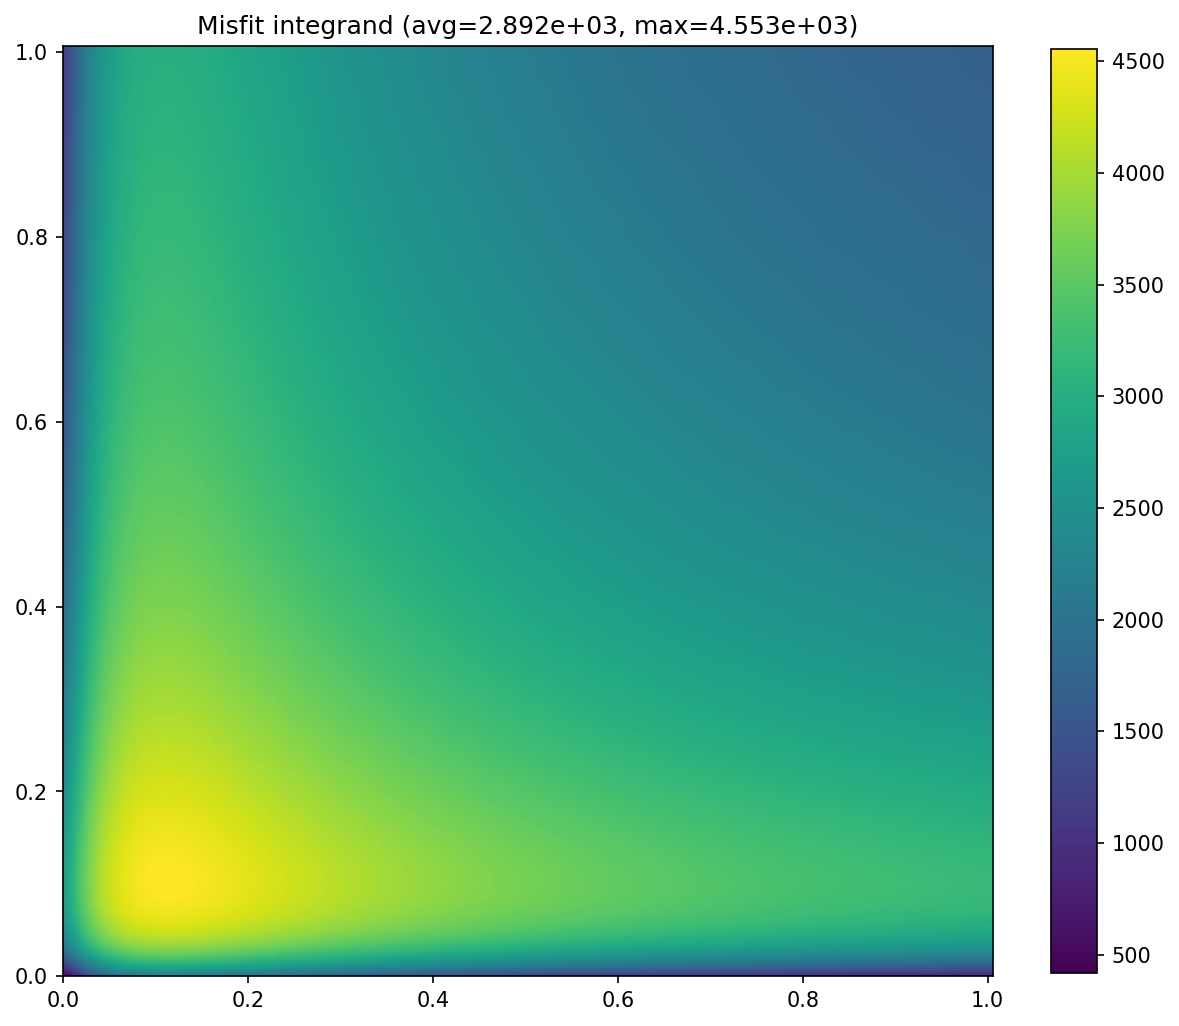

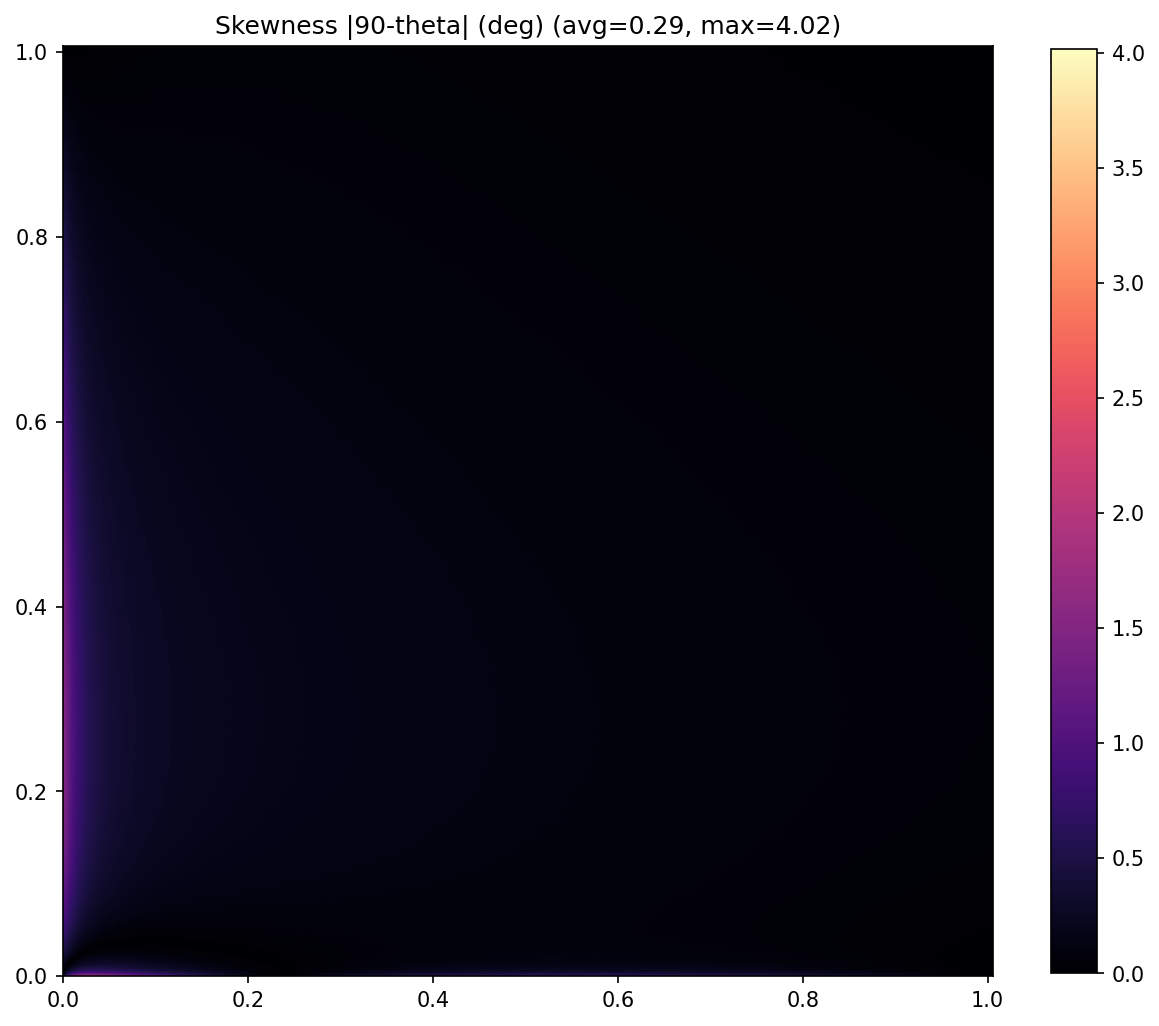

In [11]:
def metric_fn_selected(x1, x2):
    return M_fun_torch(x1, x2, problem=problem)

def metric_inv_fn_selected(x1, x2):
    return M_fun_inv_torch(x1, x2, problem=problem)

misfit_field = compute_misfit_field(
    net,
    X1,
    X2,
    metric_fn_selected,
    metric_inv_fn=metric_inv_fn_selected,
    device=device,
    dtype=dtype,
    formulation=formulation,
)
misfit_avg = float(np.mean(misfit_field))
misfit_max = float(np.max(misfit_field))
plot_scalar_field(
    X,
    Y,
    misfit_field,
    title=f"Misfit integrand (avg={misfit_avg:.3e}, max={misfit_max:.3e})",
)

skew_field = compute_skewness(X, Y)
skew_avg = float(np.mean(skew_field))
skew_max = float(np.max(skew_field))
plot_scalar_field(
    X,
    Y,
    skew_field,
    title=f"Skewness |90-theta| (deg) (avg={skew_avg:.2f}, max={skew_max:.2f})",
    cmap="magma",
)
plt.show()
